In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from datetime import datetime
from datetime import timedelta
import re
import random
import math
from collections import Counter

In [2]:
# loading data
codes = pd.read_csv('../results/patients_w_codes.csv')

In [3]:
# version with dates into strings
codes2 = pd.read_csv('../results/patients_w_codes2.csv')

In [4]:
# to use a dict with the dates in the strings
def separate_date(df):
    df['first_event_date'] = 'NA'
    for i in range(len(df)):
        x = re.split(']', df['code'][i].replace('[', ''))
        df['first_event_date'][i] = x[0]
        df['code'][i] = x[1]
    return df

In [5]:
separate_date(codes2)
codes2

,id,code,first_event_date
0,005cad4958846409,B42A40A2H1F10A15B21B7B12I24I7F6B28B128A4D77B64...,2020-08-14
1,0065b57e5a9e784f,A37B234F4B4B8B2F2B2F3B4F0G3B2I8G17I215I82B9B23A,2020-03-26
2,006e5a1bf72e8b73,B56B7B35B11B3B11B10B13B14B8A178I21I123B6B5B6B5...,2020-06-02
3,009d11a2497f1d47,A334C142J,2020-10-14
4,00a5cf0620b6adfc,A201J213A,2020-10-26
...,...,...,...
3298,ff32e199c9482c20,B196B12B21B6F1B7B1I6B6A15B7B7I70B14B78B7B7B8B5...,2020-05-07
3299,ff46357762ea097e,B92B99B12B9B6B4B32F6I4B18I232C4A14B17I79D36B3B...,2020-04-20
3300,ff9318bd975b7050,A16A64B74B14A197I,2020-08-10
3301,ffabda76a8fbaecd,B24B182A12B13B7B6F1B0I7B1B5B7F1I56B15F218B4F10...,2020-05-05


In [6]:
# Function to split strings
def split_string(s):
    """
    s is a string code. Returns two lists, with letters (A) and numbers (B).
    """
    S = []
    for x in re.split('(\d+)', s):
        try:
            S.append(int(x))
        except ValueError:
            S.append(x)
    A, B = S[::2], S[1::2]
    return A, B

In [7]:
# functions to obtain cases without dates
def case1(A, B, pos, neg):
    """
    Recognises case 1 reinfections (+|-|+).
    Added some lines to detect certain cases 2.
    """
    if A[0] in pos:
        i = 0
        c = B[i]
        # to find case 2 before case 1
        #if A[i] in pos and A[i+1] in pos and B[i] >= 90:
        #    return 'Case 2', A[i+1:len(A)], B[i+1:len(B)]
        if A[i+1] in pos and c >= 90:
            return 'Case 2', A[i+1:len(A)], B[i+1:len(B)]
        while A[i+1] not in neg:
            i += 1
            c += B[i]
            # to find case 2 before case 1
            if A[i+1] in pos and c >= 90:
                return 'Case 2', A[i+1:len(A)], B[i+1:len(B)]
        # here the first neg is found
        i += 1
        c += B[i]
        while A[i+1] not in pos:
            i += 1
            c += B[i]
        if c >= 90:
            return 'Case 1', A[i+1:len(A)], B[i+1:len(B)]
        elif c >= 60:
            return 'Possible case 1', A[i+1:len(A)], B[i+1:len(B)]
        else:
            return '', A[i+1:len(A)], B[i+1:len(B)]
    else:
        i = 0
        while A[i] not in pos:
            i += 1
        c = B[i]
        # same as above
        if A[i+1] in pos and c >= 90:
            return 'Case 2', A[i+1:len(A)], B[i+1:len(B)]
        while A[i+1] not in neg:
            i += 1
            c += B[i]
            if A[i+1] in pos and c >= 90:
                return 'Case 2', A[i+1:len(A)], B[i+1:len(B)]
        i += 1
        c += B[i]
        while A[i+1] not in pos:
            i += 1
            c += B[i]
        if c >= 90:
            return 'Case 1', A[i+1:len(A)], B[i+1:len(B)]
        elif c >= 60:
            return 'Possible case 1', A[i+1:len(A)], B[i+1:len(B)]
        else:
            return '', A[i+1:len(A)], B[i+1:len(B)]

def case2(A, B, pos):
    """
    Recognises case 2 reinfections (+|+)
    """
    c = 0
    if A[0] in pos:
        for i in range(len(B)):
            if A[i+1] not in pos:
                if bool([x for x in A[i+1:len(A)] if(x in pos)]) == False:
                    if c >= 60:
                        return 'Possible Case 2', A[i:len(A)], B[i:len(B)]
                    else:
                        return '', A[i:len(A)], B[i:len(B)]
                c += B[i]
            else:
                if c + B[i] >= 90:
                    return 'Case 2', A[i+1:len(A)], B[i+1:len(B)]
                c = B[i]
        if c >= 60:
            return 'Possible Case 2', A[i+1:len(A)], B[i+1:len(B)]
        else:
            return '', A[i+1:len(A)], B[i+1:len(B)]
    else:
        i = 0
        while A[i] not in pos:
            i += 1
        for j in range(i, len(B)):
            if A[j+1] not in pos:
                if bool([x for x in A[j+1:len(A)] if(x in pos)]) == False:
                    if c >= 60:
                        return 'Possible Case 2', A[j:len(A)], B[j:len(B)]
                    else:
                        return '', A[j:len(A)], B[j:len(B)]
                c += B[j]
            else:
                if c + B[j] >= 90:
                    return 'Case 2', A[j+1:len(A)], B[j+1:len(B)]
                c = B[j]
        if c >= 60:
            return 'Possible Case 2', A[j+1:len(A)], B[j+1:len(B)]
        else:
            return '', A[j+1:len(A)], B[j+1:len(B)]

In [8]:
def sum_date(date, days_list):
    return str(datetime.strptime(date, '%Y-%m-%d').date() + timedelta(days = sum(days_list)))

In [9]:
# functions to obtain cases with dates
def case1d(A, B, pos, neg, date = ''):
    """
    Recognises case 1 reinfections (+|-|+).
    Added some lines to detect certain cases 2.
    """
    if A[0] in pos:
        i = 0
        c = B[i]
        # to find case 2 before case 1
        #if A[i] in pos and A[i+1] in pos and B[i] >= 90:
        #    return 'Case 2', A[i+1:len(A)], B[i+1:len(B)]
        if A[i+1] in pos and c >= 90:
            return 'Case 2', A[i+1:len(A)], B[i+1:len(B)], date, sum_date(date, B[:i+1])
        while A[i+1] not in neg:
            i += 1
            c += B[i]
            # to find case 2 before case 1
            if A[i+1] in pos and c >= 90:
                return 'Case 2', A[i+1:len(A)], B[i+1:len(B)], date, sum_date(date, B[:i+1])
        # here the first neg is found
        i += 1
        c += B[i]
        while A[i+1] not in pos:
            i += 1
            c += B[i]
        if c >= 90:
            return 'Case 1', A[i+1:len(A)], B[i+1:len(B)], date, sum_date(date, B[:i+1])
        elif c >= 60:
            return 'Possible case 1', A[i+1:len(A)], B[i+1:len(B)], date, sum_date(date, B[:i+1])
        else:
            return '', A[i+1:len(A)], B[i+1:len(B)], date, sum_date(date, B[:i+1])
    else:
        i = 0
        while A[i] not in pos:
            i += 1
        j = i # index of first infection
        c = B[i]
        # same as above
        if A[i+1] in pos and c >= 90:
            return 'Case 2', A[i+1:len(A)], B[i+1:len(B)], sum_date(date, B[:j]), sum_date(date, B[:i+1])
        while A[i+1] not in neg:
            i += 1
            c += B[i]
            if A[i+1] in pos and c >= 90:
                return 'Case 2', A[i+1:len(A)], B[i+1:len(B)], sum_date(date, B[:j]), sum_date(date, B[:i+1])
        i += 1
        c += B[i]
        while A[i+1] not in pos:
            i += 1
            c += B[i]
        if c >= 90:
            return 'Case 1', A[i+1:len(A)], B[i+1:len(B)], sum_date(date, B[:j]), sum_date(date, B[:i+1])
        elif c >= 60:
            return 'Possible case 1', A[i+1:len(A)], B[i+1:len(B)], sum_date(date, B[:j]), sum_date(date, B[:i+1])
        else:
            return '', A[i+1:len(A)], B[i+1:len(B)], sum_date(date, B[:j]), sum_date(date, B[:i+1])

In [10]:
def case2d(A, B, pos, date = ''):
    """
    Recognises case 2 reinfections (+|+)
    """
    c = 0
    if A[0] in pos:
        for i in range(len(B)):
            if A[i+1] not in pos:
                if bool([x for x in A[i+1:len(A)] if(x in pos)]) == False:
                    if c >= 60:
                        return 'Possible Case 2', A[i:len(A)], B[i:len(B)], date, sum_date(date, B[:i+1])
                    else:
                        return '', A[i:len(A)], B[i:len(B)], date, sum_date(date, B[:i+1])
                c += B[i]
            else:
                if c + B[i] >= 90:
                    return 'Case 2', A[i+1:len(A)], B[i+1:len(B)], date, sum_date(date, B[:i+1])
                c = B[i]
        if c >= 60:
            return 'Possible Case 2', A[i+1:len(A)], B[i+1:len(B)], date, sum_date(date, B[:i+1])
        else:
            return '', A[i+1:len(A)], B[i+1:len(B)], date, sum_date(date, B[:i+1])
    else:
        i = 0
        while A[i] not in pos:
            i += 1
        k = i
        for j in range(i, len(B)):
            if A[j+1] not in pos:
                if bool([x for x in A[j+1:len(A)] if(x in pos)]) == False:
                    if c >= 60:
                        return 'Possible Case 2', A[j:len(A)], B[j:len(B)], sum_date(date, B[:k]), sum_date(date, B[:j])
                    else:
                        return '', A[j:len(A)], B[j:len(B)], sum_date(date, B[:k]), sum_date(date, B[:j])
                c += B[j]
            else:
                if c + B[j] >= 90:
                    return 'Case 2', A[j+1:len(A)], B[j+1:len(B)], sum_date(date, B[:k]), sum_date(date, B[:j+1])
                c = B[j]
        if c >= 60:
            return 'Possible Case 2', A[j+1:len(A)], B[j+1:len(B)], sum_date(date, B[:k]), sum_date(date, B[:j+1])
        else:
            return '', A[j+1:len(A)], B[j+1:len(B)], sum_date(date, B[:k]), sum_date(date, B[:j+1])

In [11]:
# adding multiple reinfection management
def classif(s, pos = ['A', 'C', 'D'], neg = ['B'], date = ''):
    """
    Takes a string and classifies it into reinfection cases 1 or 2
    """
    A, B = split_string(s)
    L = []
    D = []
    d1 = ''
    d2 = ''
    while len(A) > 1:
        # indices stores a list between the first and last positive in the string
        indices = [i for i, x in enumerate(A) if x in pos]
        # b will be used to break the loop if there are no positives in the remaining string
        b = [x for x in A[1:len(A)] if(x in pos)]
        if any(n in A[min(indices):max(indices)] for n in neg):
            if date == '':
                r, A, B = case1(A, B, pos, neg)
            else:
                r, A, B, d1, d2 = case1d(A, B, pos, neg, date)
                date = d2
            if r != '':
                L.append(r)
                D.append([d1, d2])
            #print('Case 1', A)
        elif bool(b) == False:
            break
        else:
            if date == '':
                r, A, B = case2(A, B, pos)
            else:
                r, A, B, d1, d2 = case2d(A, B, pos, date)
                date = d2
            #print('Case 2', A)
            if r != '':
                L.append(r)
                D.append([d1, d2])
    if date != '':
        return L, D
    return L

In [12]:
# option for taking antigen tests into account
classif('B26A9B187F40F96F63F77A', pos = ['A', 'C', 'D', 'E'], neg = ['B', 'F'], date = '2021-06-05')

(['Case 1'], [['2021-07-01', '2022-10-16']])

In [13]:
# trying random strings
r = random.randint(0,3303)
print(codes.iloc[r]['id'], '\n')
s = codes.iloc[r]['code']

A, B = split_string(s)

print(s, '\n')

#classif(s)
case1(A, B, pos = ['A', 'C', 'D'], neg = ['B'])
#case2(A, B, pos = ['A', 'C', 'D'])

f85ba59b14eb3163 

B6B53A9A8A0G45G49I23I114B40G105F49J20B16A28E 



('Case 1', ['A', 'E'], [28])

In [14]:
# applying function
d = {}
for x in codes['id']:
    d[str(x)] = classif(codes.loc[codes['id'] == x]['code'].values[0])

In [200]:
import csv

with open('../results/dict.csv', 'w') as f:
    for key in d.keys():
        f.write("%s, %s\n" % (key, d[key]))

In [15]:
# writing dictionary with strings and dates
D = {}
for x in codes2['id']:
    D[str(x)] = [codes2.loc[codes2['id'] == x]['first_event_date'].values[0],
                codes2.loc[codes2['id'] == x]['code'].values[0],
                classif(codes2.loc[codes2['id'] == x]['code'].values[0])]


In [289]:
with open('../results/dict2.csv', 'w') as f:
    for key in D.keys():
        f.write("%s, %s, %s, %s\n" % (key, D[key][0], D[key][1], D[key][2]))

In [16]:
N = list(d.values())
N = [str(x) for x in N]
freq = {}
for items in N:
    freq[items] = N.count(items)
freq

{"['Case 1']": 2109,
 "['Case 2']": 996,
 "['Case 2', 'Case 2']": 5,
 "['Case 1', 'Case 1']": 99,
 "['Possible case 1']": 26,
 "['Case 2', 'Case 1']": 17,
 '[]': 18,
 "['Case 1', 'Possible case 1']": 5,
 "['Possible case 1', 'Case 1']": 10,
 "['Case 1', 'Case 2']": 2,
 "['Possible Case 2']": 8,
 "['Case 1', 'Case 1', 'Possible case 1']": 2,
 "['Case 1', 'Possible case 1', 'Case 1']": 2,
 "['Case 2', 'Possible Case 2']": 1,
 "['Case 1', 'Case 1', 'Case 1']": 1,
 "['Possible case 1', 'Possible case 1']": 2}

In [17]:
# cases 1 
C1 = {}
for key in D.keys():
    if D[key][2] == ['Case 1']:
        C1[key] = D[key]

In [18]:
C1['ae769a9c1b782eaf']

['2020-10-09', 'B20A85B94B46A88J129F8E', ['Case 1']]

In [19]:
# function for selecting cases 1 with only two positives in their strings
def two_pos(S, pos = ['A', 'C', 'D']):
    l = []
    for p,c in enumerate(S):
        if(c in pos):
            l.append(p)
    if len(l) == 2:
        return True

In [20]:
FC1 = {}
for key in C1.keys():
    if two_pos(C1[key][1]):
        FC1[key] = C1[key]

In [21]:
len(FC1)

1235

In [22]:
# Discarding sequenced samples
def find_sequenced(s):
    if not 'C' in s:
        return 'Not sequenced'
    l = [x for x in s if(x in ['A', 'C', 'D'])]
    if l == ['C', 'C']:
        return 'Both sequenced'
    if l[0] == 'C':
        return 'First PCR sequenced'
    if l[1] == 'C':
        return 'Second PCR sequenced'

In [23]:
FC1_seq = {}
for k in FC1.keys():
    FC1_seq[k] = find_sequenced(FC1[k][1])

In [24]:
M = list(FC1_seq.values())
M = [str(x) for x in M]
freq = {}
for items in M:
    freq[items] = M.count(items)
freq

{'Not sequenced': 989,
 'Second PCR sequenced': 206,
 'First PCR sequenced': 32,
 'Both sequenced': 8}

In [67]:
# exploring no reinfections
NO = {}
for key in D.keys():
    if D[key][2] == []:
        NO[key] = D[key]
        
# NO

In [288]:
# saving dict
with open('../results/filtered_dict.csv', 'w') as f:
    for key in FC1.keys():
        f.write("%s, %s, %s\n" % (key, FC1[key][0], FC1[key][1]))

In [25]:
# accounting for antigen tests
a = {}
for x in codes2['id']:
    a[str(x)] = classif(codes2.loc[codes2['id'] == x]['code'].values[0], 
                        pos = ['A', 'C', 'D', 'E'], neg = ['B', 'F'])

In [26]:
M = list(a.values())
M = [str(x) for x in M]
freq = {}
for items in M:
    freq[items] = M.count(items)
freq

{"['Case 1']": 2344,
 "['Case 2']": 652,
 "['Case 2', 'Case 1']": 47,
 "['Case 2', 'Case 2']": 6,
 "['Case 1', 'Case 1']": 158,
 "['Possible case 1']": 26,
 "['Case 1', 'Case 1', 'Case 1']": 4,
 '[]': 13,
 "['Case 1', 'Case 2']": 11,
 "['Case 1', 'Possible case 1']": 11,
 "['Possible case 1', 'Case 1']": 15,
 "['Case 1', 'Possible Case 2']": 2,
 "['Case 1', 'Case 1', 'Possible case 1']": 2,
 "['Case 1', 'Possible case 1', 'Case 1']": 2,
 "['Possible Case 2']": 6,
 "['Possible case 1', 'Case 1', 'Case 1']": 2,
 "['Possible case 1', 'Possible case 1']": 1,
 "['Possible case 1', 'Possible case 1', 'Case 1']": 1}

In [27]:
# FUNCTIONS FOR VARIANT ASSIGNMENT

# prealpha: start (2020-03-13) --> 2021-02-01
# alpha: 2021-02-08 --> 2021-06-21
# delta: 2021-06-28 --> 2021-12-13
# omicron: 2021-12-20 --> end (2022-05-21)

# function to obtain the last event date
def last_date(date, string):
    L, N = split_string(string)
    d = sum(N)
    return str(datetime.strptime(date, '%Y-%m-%d').date() + timedelta(days = d))

In [28]:
last_date(codes2['first_event_date'][0], codes2['code'][0])

'2022-03-15'

In [29]:
ld_list = []
for i in range(len(codes2)):
    ld_list.append(last_date(codes2['first_event_date'][i], codes2['code'][i]))

In [30]:
len(ld_list)

3303

In [31]:
# obtaining first and last date
print(min(codes2['first_event_date']))
print(max(ld_list))

2020-03-13
2022-05-21


In [151]:
# testing dates obtention
r = random.randint(0,3303)
s = codes2.iloc[r]['code']
dat = codes2.iloc[r]['first_event_date']

print(s, '\n', dat)

classif(s, pos = ['A', 'C', 'D'], neg = ['B'], date = dat)

A191B145B14B6I1B7B7B7B0I7B28B53B14B49B14A40F 
 2020-07-24


(['Case 1'], [['2020-07-24', '2022-01-18']])

In [146]:
sum_date('2020-03-29', [46,132,97,14,2,12,9,5,14,14,90,186,4,8,1,4,16,13])

'2022-01-25'

In [33]:
# obtaining all dates
# we will only use PCR/TMA
dates_dict = {}
for x in codes2['id']:
    dates_dict[str(x)] = classif(codes2.loc[codes2['id'] == x]['code'].values[0], 
                        pos = ['A', 'C', 'D'], neg = ['B'], 
                        date = codes2.loc[codes2['id'] == x]['first_event_date'].values[0])

In [34]:
# function for classifying reinfections in 10 categories (combinations of pre-alpha, alpha, delta, omicron)
def probable_variant(date1, date2):
    a = datetime.strptime('2021-02-08', '%Y-%m-%d').date() # alpha start
    d = datetime.strptime('2021-06-28', '%Y-%m-%d').date() # delta start
    o = datetime.strptime('2021-12-20', '%Y-%m-%d').date() # omicron start
    date1 = datetime.strptime(date1, '%Y-%m-%d').date()
    date2 = datetime.strptime(date2, '%Y-%m-%d').date()
    if date1 < a:
        if date2 < a:
            return 'pre-alpha:pre-alpha'
        if date2 < d:
            return 'pre-alpha:alpha'
        if date2 < o:
            return 'pre-alpha:delta'
        else:
            return 'pre-alpha:omicron'
    if date1 < d:
        if date2 < d:
            return 'alpha:alpha'
        if date2 < o:
            return 'alpha:delta'
        else:
            return 'alpha:omicron'
    if date1 < o:
        if date2 < o:
            return 'delta:delta'
        else:
            return 'delta:omicron'
    else:
        return 'omicron:omicron'

In [35]:
probable_variant('2020-04-12', '2022-01-19')

'pre-alpha:omicron'

In [36]:
variants = {}
for k, v in dates_dict.items():
    l = []
    for x in list(v)[1]:
        l.append(probable_variant(x[0], x[1]))
    variants[k] = l

In [37]:
V = list(variants.values())
V = [str(x) for x in V]
freq = {}
for items in V:
    freq[items] = V.count(items)
freq

{"['pre-alpha:delta']": 527,
 "['pre-alpha:omicron']": 1284,
 "['pre-alpha:pre-alpha']": 311,
 "['pre-alpha:alpha']": 233,
 "['delta:omicron']": 439,
 "['pre-alpha:pre-alpha', 'pre-alpha:delta']": 11,
 "['alpha:omicron']": 198,
 "['pre-alpha:delta', 'delta:omicron']": 47,
 "['delta:delta']": 56,
 "['pre-alpha:delta', 'delta:delta']": 3,
 "['alpha:delta']": 86,
 "['alpha:alpha']": 5,
 "['pre-alpha:alpha', 'alpha:omicron']": 23,
 "['pre-alpha:alpha', 'alpha:delta']": 9,
 "['pre-alpha:pre-alpha', 'pre-alpha:omicron']": 30,
 '[]': 18,
 "['alpha:delta', 'delta:delta']": 1,
 "['pre-alpha:pre-alpha', 'pre-alpha:alpha']": 4,
 "['pre-alpha:pre-alpha', 'pre-alpha:pre-alpha']": 2,
 "['alpha:delta', 'delta:omicron']": 7,
 "['pre-alpha:pre-alpha', 'pre-alpha:pre-alpha', 'pre-alpha:pre-alpha']": 1,
 "['pre-alpha:pre-alpha', 'pre-alpha:pre-alpha', 'pre-alpha:omicron']": 1,
 "['pre-alpha:pre-alpha', 'pre-alpha:alpha', 'alpha:delta']": 1,
 "['alpha:alpha', 'alpha:delta']": 1,
 "['pre-alpha:delta', 'del

In [81]:
# saving dictionary
with open('../results/possible_variants.csv', 'w') as f:
    for key in variants.keys():
        if len(variants[key]) == 0:
            f.write("%s,,,\n" % key)
        elif len(variants[key]) == 1:
            f.write("%s,%s,,\n" % (key, variants[key][0]))
        elif len(variants[key]) == 2:
            f.write("%s,%s,%s,\n" % (key, variants[key][0], variants[key][1]))
        elif len(variants[key]) == 3:
            f.write("%s,%s,%s,%s\n" % (key, variants[key][0], variants[key][1], variants[key][2]))

In [38]:
# getting counts of each variant
# removing emptly values
lista = []
lista2 = list(variants.values())
for i in range(len(lista2)):
    if lista2[i] != []:
        lista.append(lista2[i])
len(lista)

3285

In [39]:
# separating list into first, second, and third reinfection
lista1 = []
lista2 = []
lista3 = []
for e in lista:
    if len(e) == 1:
        lista1.append(e[0])
    elif len(e) == 2:
        lista1.append(e[0])
        lista2.append(e[1])
    elif len(e) == 3:
        lista1.append(e[0])
        lista2.append(e[1])
        lista3.append(e[2])

In [40]:
# from lista2 and lista3 we will only count last variant
countv = []
for e in lista2:
    countv.append(e.split(':')[1])
for e in lista3:
    countv.append(e.split(':')[1])

In [41]:
# we will add both variants from lista1
for e in lista1:
    countv.append(e.split(':')[0])
    countv.append(e.split(':')[1])

In [42]:
len(countv)

6721

In [43]:
Counter(countv)

Counter({'delta': 1256, 'omicron': 2035, 'alpha': 574, 'pre-alpha': 2856})

In [44]:
# We will characterize time between infections
# we will omit multiple reinfections (only counting the first reinfection)
first = []
for v in dates_dict.values():
    try:
        first.append(v[1][0])
    except IndexError:
        pass

In [45]:
days_first = []
for x in first:
    days_first.append((datetime.strptime(x[1], '%Y-%m-%d') - datetime.strptime(x[0], '%Y-%m-%d')).days)

''

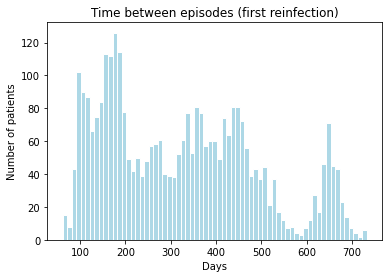

In [46]:
import matplotlib.pyplot as plt

plt.hist(days_first, color = 'lightblue', edgecolor = 'white',
         bins = int((max(days_first)-min(days_first))/10))

plt.title('Time between episodes (first reinfection)')
plt.xlabel('Days')
plt.ylabel('Number of patients')
;

/home/fmunoz/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

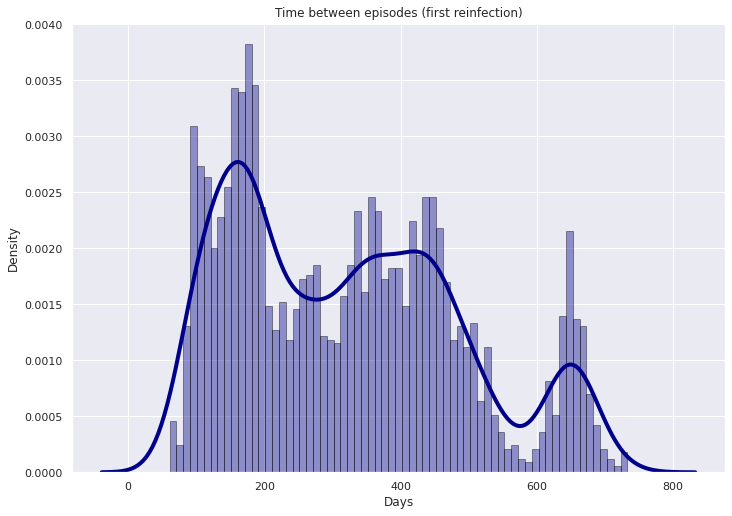

In [206]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

# different representation

sns.distplot(days_first, hist=True, kde=True, 
             bins=int((max(days_first)-min(days_first))/10),
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Time between episodes (first reinfection)')
plt.xlabel('Days')
plt.ylabel('Density')
;

In [48]:
# Second reinfection
second = []
for v in dates_dict.values():
    try:
        second.append(v[1][1])
    except IndexError:
        pass
    
days_second = []
for x in second:
    days_second.append((datetime.strptime(x[1], '%Y-%m-%d') - datetime.strptime(x[0], '%Y-%m-%d')).days)

/home/fmunoz/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

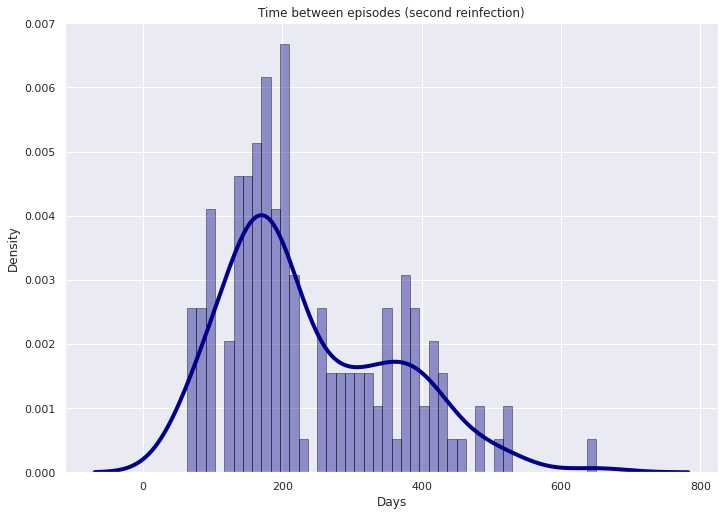

In [207]:
sns.distplot(days_second, hist=True, kde=True, 
             bins=int((max(days_first)-min(days_first))/15),
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Time between episodes (second reinfection)')
plt.xlabel('Days')
plt.ylabel('Density')
;

/home/fmunoz/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

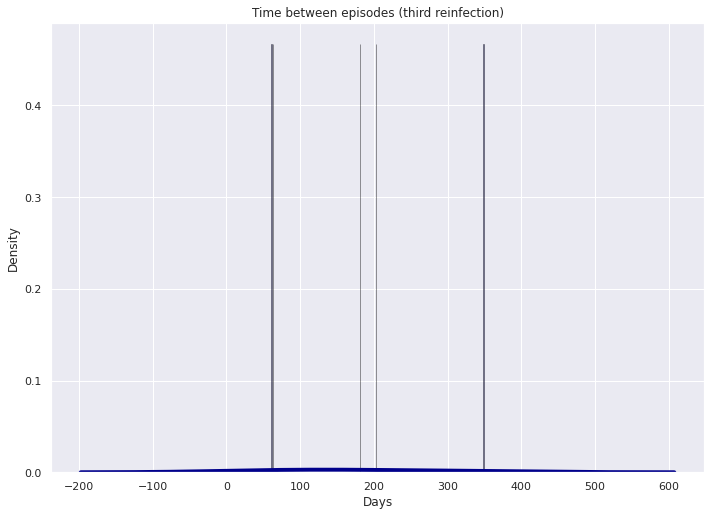

In [208]:
# third reinfection
third = []
for v in dates_dict.values():
    try:
        third.append(v[1][2])
    except IndexError:
        pass
    
days_third = []
for x in third:
    days_third.append((datetime.strptime(x[1], '%Y-%m-%d') - datetime.strptime(x[0], '%Y-%m-%d')).days)
    
sns.distplot(days_third, hist=True, kde=True, 
             bins=int((max(days_first)-min(days_first))),
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Time between episodes (third reinfection)')
plt.xlabel('Days')
plt.ylabel('Density')
;

In [182]:
# let's label the first PCR of each episode
twopcr = pd.read_csv('../data/new_version/main_sheet.csv', sep = ';')

In [183]:
twopcr = twopcr[['ID_ANONIMITZAT', 'ETIQUETA_1_ANOMIM', 'DATA POSITIU 1', 'ETIQUETA_2_ANOMIM', 'DATA POSITIU 2']]

In [184]:
otherpcrs = pd.read_csv('../data/new_version/pcrs.csv', sep = ';')

In [185]:
otherpcrs = otherpcrs[otherpcrs['PROVA'] == 'PCR']

In [186]:
otherpcrs = otherpcrs[otherpcrs['RESULTAT'] == 'Positiu']

In [187]:
otherpcrs = otherpcrs[['ID_ANONIMITZAT', 'DATA', 'ETIQUETA_ANONIM']]
otherpcrs = otherpcrs.rename({'ID_ANONIMITZAT':'id', 'DATA':'date', 'ETIQUETA_ANONIM':'label'}, axis = 1)

In [188]:
# arranging twopcr
twopcr1 = twopcr[['ID_ANONIMITZAT', 'DATA POSITIU 1', 'ETIQUETA_1_ANOMIM']]
twopcr1 = twopcr1.rename({'ID_ANONIMITZAT':'id', 'DATA POSITIU 1':'date', 'ETIQUETA_1_ANOMIM':'label'}, axis = 1)
twopcr2 = twopcr[['ID_ANONIMITZAT', 'DATA POSITIU 2', 'ETIQUETA_2_ANOMIM']]
twopcr2 = twopcr2.rename({'ID_ANONIMITZAT':'id', 'DATA POSITIU 2':'date', 'ETIQUETA_2_ANOMIM':'label'}, axis = 1)

In [189]:
mainpcrs = pd.concat([twopcr1, twopcr2])

In [190]:
# removing possible duplicates
mainpcrs = mainpcrs.drop_duplicates()
otherpcrs = otherpcrs.drop_duplicates()

In [191]:
# we need to change the date format
fechas = []
for d in mainpcrs['date']:
    fechas.append(str(datetime.strptime(d, '%d/%m/%Y').date()))

mainpcrs['date'] = fechas

In [192]:
fechas = []
for d in otherpcrs['date']:
    fechas.append(str(datetime.strptime(d, '%m/%d/%Y').date()))

otherpcrs['date'] = fechas

In [193]:
# joining dataframes
pcrs = pd.concat([mainpcrs, otherpcrs])
len(pcrs)

15414

In [194]:
# sorting df
pcrs = pcrs.sort_values(by = 'id')
pcrs = pcrs.reset_index(drop = True)

In [195]:
pcrs = pcrs.drop_duplicates()

In [196]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

take(5, dates_dict.items())

[('005cad4958846409', (['Case 1'], [['2020-09-25', '2021-07-23']])),
 ('0065b57e5a9e784f', (['Case 1'], [['2020-03-26', '2022-01-14']])),
 ('006e5a1bf72e8b73', (['Case 1'], [['2020-11-17', '2021-11-07']])),
 ('009d11a2497f1d47', (['Case 2'], [['2020-10-14', '2021-09-13']])),
 ('00a5cf0620b6adfc', (['Case 2'], [['2020-10-26', '2021-12-14']]))]

In [197]:
# getting dates of first PCR of first and second episode
k = []
v = []
for x in dates_dict.keys():
    try:
        v.append(dates_dict[x][1][0][0])
        v.append(dates_dict[x][1][0][1])
        k.append(x)
        k.append(x)
    except IndexError: # avoiding empty values
        pass

In [198]:
tolabel = pd.DataFrame(data = {'id':k, 'date':v})

In [203]:
labels = pd.merge(tolabel, pcrs, on = ['id', 'date'])

In [204]:
# labels of first PCR of 1st and 2nd episode
labels

,id,date,label
0,005cad4958846409,2020-09-25,39f6cdad6da41b7a2859bb35a23fb6e1
1,005cad4958846409,2021-07-23,2c0e42e7c3ab6c403c92509dbe41addf
2,0065b57e5a9e784f,2020-03-26,cdbee5316fd40f0e7693e10ad17e032e
3,0065b57e5a9e784f,2022-01-14,c89a8ef002f5963d9c5f68571c6b51d2
4,006e5a1bf72e8b73,2020-11-17,b349230151f241423c92509dbe41addf
...,...,...,...
6551,ff9318bd975b7050,2021-01-25,ef5941b7993c83053c92509dbe41addf
6552,ffabda76a8fbaecd,2020-11-27,c81dcd0ede2fa37e9c5f68571c6b51d2
6553,ffabda76a8fbaecd,2022-01-17,fec243b129461923753c712f07de27fe
6554,ffc2d5ab7d2ad39e,2020-10-17,2ecd0634b087998a1f2b47738c0d648a


In [205]:
# saving dataframe
labels.to_csv('../data/new_version/first_pcr_labels.csv', index = False, sep = ';')

In [255]:
# adding case 1/2
labels['case'] = ''
for i in dates_dict.keys():
    try:
        labels.loc[labels['id'] == i, 'case'] = dates_dict[i][0][0]
    except IndexError:
        pass

In [243]:
# adding sequencing info
# loading data
seqqq = pd.read_csv('../data/patients_vaccines.csv', sep = '\t')
seqqq = seqqq[['ID_ANONIMITZAT', 'ETIQUETA_1_ANOMIM', 'SEQ_MOSTRA_1',
              'ETIQUETA_2_ANOMIM', 'SEQ_MOSTRA_2']]

In [251]:
seqqq = seqqq.rename({'ID_ANONIMITZAT':'id', 'ETIQUETA_1_ANOMIM':'label1',
                   'SEQ_MOSTRA_1':'seq1', 'ETIQUETA_2_ANOMIM':'label2',
                   'SEQ_MOSTRA_2':'seq2'}, axis = 1)

In [296]:
labels['seq'] = '?'
for x in labels['label']:
    if x in list(seqqq['label1']):
        valor = seqqq.loc[seqqq['label1'] == x, 'seq1'].to_string(index = False)
        labels.loc[labels['label'] == x, 'seq'] = valor
    elif x in list(seqqq['label2']):
        valor = seqqq.loc[seqqq['label2'] == x, 'seq2'].to_string(index = False)
        labels.loc[labels['label'] == x, 'seq'] = valor

In [299]:
labels['seq'].unique()

array(['NaN\nNaN', 'NaN', 'X', '?', 'X\nX', 'NaN\n  X'], dtype=object)

In [302]:
labels.loc[labels['seq'] == 'NaN\n  X']
# same label asigned to 2 patients/PCRs - discard??

,id,date,label,case,seq
1731,4503707174185538,2022-01-21,448c40b818e5ff3f499353abde37bb26,Case 1,NaN\n X
5688,de6b49e26d06de53,2021-06-15,448c40b818e5ff3f499353abde37bb26,Case 1,NaN\n X


In [308]:
# changing values for clearer ones
labels['seq'] = labels['seq'].replace(['NaN\nNaN', 'NaN', 'X', '?', 'X\nX', 'NaN\n  X'],
                                     ['No', 'No', 'Yes', 'Unknown', 'Yes', 'Labeling error'])

In [312]:
labels['seq'].value_counts()

No                5579
Yes                674
Unknown            301
Labeling error       2
Name: seq, dtype: int64

In [313]:
# saving table
labels.to_csv('../data/new_version/first_pcrs_labels2.tsv', sep = '\t', index = False)

In [319]:
# labels of patients with at least one episode sequenced
sequenced_labels = labels.loc[labels['id'].isin([x for x in list(FC1_seq.keys()) if FC1_seq[x] != 'Not sequenced'])]

In [345]:
# adding probable variant
sequenced_labels['prob_variant'] = ''
alpha = datetime.strptime('2021-02-08', '%Y-%m-%d').date() # alpha start
delta = datetime.strptime('2021-06-28', '%Y-%m-%d').date() # delta start
omicron = datetime.strptime('2021-12-20', '%Y-%m-%d').date() # omicron start
for i in range(len(sequenced_labels)):
    fecha = datetime.strptime(sequenced_labels.iloc[i]['date'], '%Y-%m-%d').date()
    if fecha < alpha:
        sequenced_labels.iloc[i, sequenced_labels.columns.get_loc('prob_variant')] = 'pre-alpha'
    elif fecha < delta:
        sequenced_labels.iloc[i, sequenced_labels.columns.get_loc('prob_variant')] = 'alpha'
    elif fecha < omicron:
        sequenced_labels.iloc[i, sequenced_labels.columns.get_loc('prob_variant')] = 'delta'
    else:
        sequenced_labels.iloc[i, sequenced_labels.columns.get_loc('prob_variant')] = 'omicron'


In [346]:
sequenced_labels

,id,date,label,case,seq,prob_variant
56,025541d83c991e99,2020-10-24,3eaab0d82c5a13e0458813d2b0595c35,Case 1,No,pre-alpha
57,025541d83c991e99,2022-01-17,68f326d82601ac723c92509dbe41addf,Case 1,Yes,omicron
74,0399ae7bc4dc5ec2,2020-12-01,6cfe035437fd45d6458813d2b0595c35,Case 1,No,pre-alpha
75,0399ae7bc4dc5ec2,2021-12-27,78c04869777939c89c5f68571c6b51d2,Case 1,Yes,omicron
86,04331717c9eea2a9,2021-01-10,984207134b0c46eb458813d2b0595c35,Case 1,No,pre-alpha
...,...,...,...,...,...,...
6297,f75c1f49e6c56565,2021-07-05,b3f52f7f33d7ca0c499353abde37bb26,Case 1,Yes,delta
6362,f9588a8e41c63419,2021-02-17,7fed91b502c7326f7693e10ad17e032e,Case 1,No,alpha
6363,f9588a8e41c63419,2022-01-18,5a3e4326fc8618dd1f2b47738c0d648a,Case 1,Yes,omicron
6462,fcd4e0c5f2f6d527,2020-10-01,5052d7d6ff749224499353abde37bb26,Case 1,No,pre-alpha


In [347]:
sequenced_labels.to_csv('../data/at_least_one_sequenced.tsv', sep = '\t', index = False)

In [354]:
# plotting distribution of selected patients
impares = [sequenced_labels.iloc[i]['prob_variant'] for i in range(0,len(sequenced_labels),2)]
pares = [sequenced_labels.iloc[i]['prob_variant'] for i in range(1,len(sequenced_labels),2)]

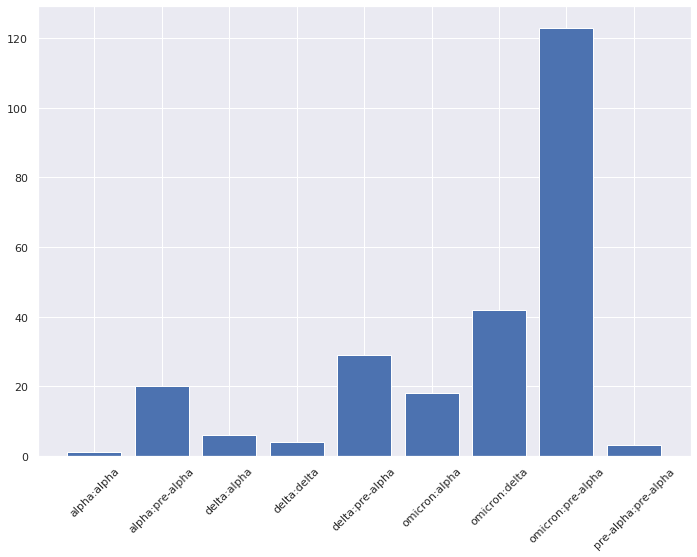

In [365]:
comb = []
for i in range(len(pares)):
    comb.append(pares[i] + ':' + impares[i])

keys, counts = np.unique(comb, return_counts=True)

plt.bar(keys, counts)
plt.xticks(rotation = 45)
plt.show()

In [322]:
# let's manage vaccines
# we will classify patients in 3 groups (based only in the first reinfection):
#     infected-vaccinated-infected
#     infected-infected-vaccinated / non-vaccinated
#     vaccinated-infected-infected
# Complete schedule
# Janssen: one dose
# AstraZeneca, Pfizer, Moderna: two doses

In [332]:
(pfizer, moderna, az, janssen, hipra) = (0, 0, 0, 0, 0)
# General proportions of vaccines
for code in codes2['code']:
    pfizer += code.count('I')
    moderna += code.count('J')
    az += code.count('K')
    janssen += code.count('L')
    hipra += code.count('M')

In [335]:
print('Pfizer: ', pfizer, '\nModerna: ', moderna, '\nAstraZeneca: ', 
      az, '\nJanssen: ', janssen, '\nHIPRA: ', hipra)
# Pfizer is the most administered vaccine, followed by Moderna, and Janssen (only one dose needed)

Pfizer:  4814 
Moderna:  1642 
AstraZeneca:  109 
Janssen:  95 
HIPRA:  1


In [507]:
# non-vaccinated patients
counter = 0
for code in codes2['code']:
    if bool([x for x in code if(x in ['I', 'J', 'K', 'L', 'M'])]) == False:
        counter += 1
counter 

378

In [429]:
# function for rejoining splitted string
def join_string(A, B):
    """
    join two list of characters in a string
    """
    B = [str(x) for x in B] # originally numeric
    C = A + B
    C[::2] = A
    C[1::2] = B
    return ''.join(C)

In [568]:
# function for indentifying breakthrough cases
def breakthrough(string):
    """
    Breakthrough: infection 14+ days after complete vaccination
    Partial breakthrough: infection between 1st and 2nd dose or <14 days after complete vaccination
    """
    A, B = split_string(string)
    
    # janssen (one dose)
    if 'J' in A:
        i = A.index('J') # index() only provides index of the first occurrence; its ok with janssen
        if sum(B[i:]) >= 14:
            return 'BT'
        else:
            return 'PBT'
        
    # moderna, astrazeneca, pfizer (two doses)
    td = ['I', 'K', 'L']
    indexes = [i for i,e in enumerate(A) if (e in td)]
    # only one dose before infection
    if len(indexes) == 1:
        return 'PBT'
    # two doses or two doses + boost
    else:
        # we will count from the second dose
        if sum(B[indexes[1]:]) >= 14:
            return 'BT'
        else:
            return 'PBT'

In [ ]:
# function for classifying patients according to vaccination status
def vacc_classif(ID):
    """
    This function needs the objects dates_dict and codes2
    """
    # we will leave HIPRA out as it is present in just one patient (last position in the code)
    vacc = ['I', 'J', 'K', 'L'] 

    # Getting code
    code = codes2.loc[codes2['id'] == ID].values[0][1]
    print(code)
    # Initial date
    f0 = datetime.strptime(codes2.loc[codes2['id'] == ID].values[0][2], 
                           '%Y-%m-%d').date()
    # Empty values
    if len(dates_dict[ID]) == 0:
        return ''
    
    # Non-vaccinated 
    if bool([x for x in codes2.loc[codes2['id'] == ID].values[0][1] if(x in vacc)]) == False:
        return 'NV'
    
    # Vaccinated
    # Extracting infection 1 and 2 starting dates
    f1 = datetime.strptime(dates_dict[ID][1][0][0], '%Y-%m-%d').date()
    f2 = datetime.strptime(dates_dict[ID][1][0][1], '%Y-%m-%d').date()
    
    # Separating string into two ranges
    
    # if the first element in code is an infection we can't define R1
    if code[0] in ['A', 'C', 'D']:
        x = (f2-f1).days
        y = 0
        A, B = split_string(code)
        for i in range(len(B)):
            y += B[i]
            if x == y:
                R2 = join_string(A[:i+2], B[:i+1])
                break
        if bool([x for x in R2 if(x in vacc)]) == True:
            return 'IVI'
        else:
            return 'IIV'
    
    # R1: from start to first infection
    x = (f1 - f0).days
    y = 0
    A, B = split_string(code)
    for i in range(len(B)):
        y += B[i]
        if x == y:
            R1 = join_string(A[:i+2], B[:i+1])
            print('\n' + R1)
            j = i
            break
    
    # R2: from first to second infection
    A, B = A[j+1:], B[j+1:]
    x = (f2 - f1).days
    y = 0
    for i in range(len(B)):
        y += B[i]
        if x == y:
            R2 = join_string(A[:i+2], B[:i+1])
            print('\n' + R2)
            break
    
    # Classification into VII, IVI, VIVI, IIV
    # FOR NOW, WE WILL IGNORE COMPLETE SCHEDULE CONCEPT
    if bool([x for x in R2 if(x in vacc)]) == True: # vaccine in R2?
        if bool([x for x in R1 if(x in vacc)]) == True: # vaccine in R1?
            return 'VIVI'
        else:
            return 'IVI'
    else:
        if bool([x for x in R1 if(x in vacc)]) == True:
            return 'VII'
        else:
            return 'IIV'

In [561]:
ID = '00a5cf0620b6adfc'
vacc_classif(ID)

A201J213A


'IVI'

In [502]:
ID = '025541d83c991e99'
codes2.loc[codes2['id'] == ID, 'first_event_date'].to_string

,id,code,first_event_date
0,005cad4958846409,B42A40A2H1F10A15B21B7B12I24I7F6B28B128A4D77B64...,2020-08-14
1,0065b57e5a9e784f,A37B234F4B4B8B2F2B2F3B4F0G3B2I8G17I215I82B9B23A,2020-03-26
2,006e5a1bf72e8b73,B56B7B35B11B3B11B10B13B14B8A178I21I123B6B5B6B5...,2020-06-02
3,009d11a2497f1d47,A334C142J,2020-10-14
4,00a5cf0620b6adfc,A201J213A,2020-10-26
...,...,...,...
3298,ff32e199c9482c20,B196B12B21B6F1B7B1I6B6A15B7B7I70B14B78B7B7B8B5...,2020-05-07
3299,ff46357762ea097e,B92B99B12B9B6B4B32F6I4B18I232C4A14B17I79D36B3B...,2020-04-20
3300,ff9318bd975b7050,A16A64B74B14A197I,2020-08-10
3301,ffabda76a8fbaecd,B24B182A12B13B7B6F1B0I7B1B5B7F1I56B15F218B4F10...,2020-05-05
